In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import combinations
from collections import Counter

from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from scipy.stats import mode

%matplotlib inline

# Loading and preparing datasets

In [2]:
# Loading feature and label names
feature_names = pd.read_csv('dataset/UCI HAR Dataset/features.txt', sep=' ', names=['name'])
label_names = pd.read_csv('dataset/UCI HAR Dataset/activity_labels.txt', sep=' ', names=['name'])

# Loading training dataset
X_train = pd.read_table('dataset/UCI HAR Dataset/train/X_train.txt', sep=' ', skipinitialspace=True, names=feature_names['name'])
y_train = pd.read_table('dataset/UCI HAR Dataset/train/y_train.txt', sep=' ', names=['name'])['name']

# Loading testing dataset
X_test = pd.read_table('dataset/UCI HAR Dataset/test/X_test.txt', sep=' ', skipinitialspace=True, names=feature_names['name'])
y_test = pd.read_table('dataset/UCI HAR Dataset/test/y_test.txt', sep=' ', names=['name'])['name']

Checking number of observation and features.

In [3]:
X_train.shape

(7352, 561)

Checking number of observations in each class. 

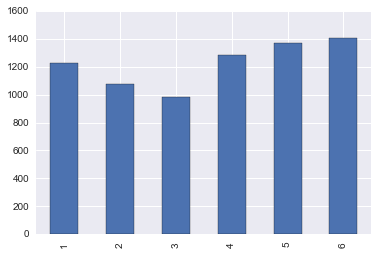

In [4]:
y_train.value_counts().sort_index().plot(kind='bar')

# Hashing function for Dimensionality Reduction

In [5]:
# Setting seed
np.random.seed(42)

# Creating random vectors
number_of_vectors = 300
random_vectors = np.random.randn(X_train.shape[1], number_of_vectors)

def hashing(x):
    return x.dot(random_vectors)

X_train_transform = hashing(np.array(X_train))

## Learning Logistic Regression without Dimensionality Reduction

In [6]:
lr = linear_model.LogisticRegression().fit(X_train, y_train)

training_baseline = metrics.f1_score(y_train, lr.predict(X_train), average='micro')
testing_baseline = metrics.f1_score(y_test, lr.predict(X_test), average='micro')

print 'training f1 score:', training_baseline
print 'testing f1 score:', testing_baseline

training f1 score: 0.990750816104
testing f1 score: 0.961316593146


## Checking Logistic Regression with hashing function

It is not hashing function, just a name.

In [7]:
lr = linear_model.LogisticRegression().fit(hashing(X_train), y_train)

print 'training f1 score:', metrics.f1_score(y_train, lr.predict(hashing(X_train)), average='micro')
print 'testing f1 score:', metrics.f1_score(y_test, lr.predict(hashing(X_test)), average='micro')

training f1 score: 0.997551686616
testing f1 score: 0.959959280624


## Searching for good number of vectors

We are looking for the best minimal number of vectors for dimensionality reduction.

In [8]:
training_results = {}
testing_results = {}

for number_of_vectors in range(10, X_train.shape[1]+1, 50):
    np.random.seed(42)
    number_of_vectors = number_of_vectors
    random_vectors = np.random.randn(X_train.shape[1], number_of_vectors)   
    
    lr = linear_model.LogisticRegression().fit(hashing(X_train), y_train)
    
    f1_training = metrics.f1_score(y_train, lr.predict(hashing(X_train)), average='micro')
    f1_testing = metrics.f1_score(y_test, lr.predict(hashing(X_test)), average='micro')
    
    training_results[number_of_vectors] = f1_training
    testing_results[number_of_vectors] = f1_testing

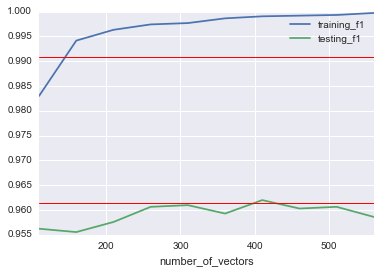

In [9]:
training_df = pd.DataFrame(training_results.items(), columns=['number_of_vectors', 'training_f1'])
testing_df = pd.DataFrame(testing_results.items(), columns=['number_of_vectors', 'testing_f1'])
result_df = training_df.merge(testing_df, on='number_of_vectors').sort_values('number_of_vectors')
result_df = result_df.set_index('number_of_vectors')

result_df[2:].plot()
plt.axhline(training_baseline, color='red', lw=1, label='training base line')
plt.axhline(testing_baseline, color='red', lw=1, label='testing base line')

## Binarizing feature vectors

In [10]:
np.random.seed(42)

number_of_vectors = 550
random_vectors = np.random.randn(X_train.shape[1], number_of_vectors)

X_train_transform = preprocessing.scale(hashing(X_train))
X_test_transform = preprocessing.scale(hashing(X_test))

lr = linear_model.LogisticRegression().fit(X_train_transform, y_train)

training_baseline = metrics.f1_score(y_train, lr.predict(X_train_transform), average='micro')
testing_baseline = metrics.f1_score(y_test, lr.predict(X_test_transform), average='micro')

print 'training f1 score:', training_baseline
print 'testing f1 score:', testing_baseline

training f1 score: 0.994559303591
testing f1 score: 0.96674584323


# Locality-Sensitive Hashing Implementation

In [13]:
class LSH(object):
    def __init__(self, number_of_vectors, seed=None, search_radius=2):
        self.number_of_vectors = number_of_vectors
        self.seed = seed
        self.search_radius = search_radius
        self._table = None
        self._random_vectors = None        
        self._training_set = None
        self._training_labels = None
        
    def __repr__(self):
        return 'LSH(number_of_vectors={}, seed={})'.format(self.number_of_vectors, self.seed)
        
    def fit(self, X, y):
        self._training_set = X
        self._training_labels = y
        dim = X.shape[1]
        
        if self.seed:
            np.random.seed(self.seed)
        
        self._random_vectors = np.random.randn(dim, self.number_of_vectors)
        powers = 1 << np.arange(self.number_of_vectors - 1, -1, -1)
        
        self._table = {}
        
        # Partition data points into bins
        bin_index_bits = X.dot(self._random_vectors) >= 0
        
        # Encode bin  index bits into integers
        bin_indices = bin_index_bits.dot(powers)
        
        # Update table so table[i] is the list of document ids with bin index equal to i
        for data_index, bin_index in enumerate(bin_indices):
            
            # If not list exists for this bin, assign the bin an empty list
            if bin_index not in self._table:
                self._table[bin_index] = []
            
            # Fetch the list of document ids associated with the bin and add the document id to the end
            self._table[bin_index].append(data_index)
            
        return self
    
    def search_nearby_bins(self, query):

        query = query.dot(self._random_vectors) >= 0
        num_vector = len(query)
        powers = 1 << np.arange(self.number_of_vectors -1, -1, -1)
        
        candidate_set = set()
        
        for different_bits in combinations(range(self.number_of_vectors), self.search_radius):
            alternate_bits = np.copy(query)
            
            for i in different_bits:
                alternate_bits[i] = not query[i]
                
            nearby_bin = alternate_bits.dot(powers)

            if nearby_bin in self._table:
                candidate_set.update(self._table[nearby_bin])
        
        return candidate_set
    
    def predict(self, X):
        candidates = X.apply(lambda x: [self._training_labels[i] for i in self.search_nearby_bins(x)], axis=1)
        
        def get_mode(x):
            try:
                return mode(x, nan_policy='omit').mode[0]
            except:
                return np.nan
        
        return np.array(candidates.map(get_mode))
        

## Using LSH for classification problem

In [14]:
lsh = LSH(number_of_vectors=30, seed=42, search_radius=1)
lsh.fit(X_train, y_train)

LSH(number_of_vectors=30, seed=42)

In [33]:
y_pred = lsh.predict(X_test.iloc[:100])
y_pred

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 4, 5,
       5, 6, 5, 5, 5, 5, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [34]:
y_true = np.array(y_test.iloc[:100])
y_true

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [35]:
np.sum(np.equal(y_pred, y_true))/ 100.0

0.73999999999999999

In [28]:
# To do: search k neighbours